# Zeisel, A. et al. Mouse Cortex

## Reference:
[Zeisel, A. et al. Brain structure. Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq. Science 347, 1138–1142 (2015)](http://dx.doi.org/10.1126/science.aaa1934)

## data source:    
https://hemberg-lab.github.io/scRNA.seq.datasets/mouse/brain/

## GEO:    
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")

from SCCAF import *

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("https://s3.amazonaws.com/scrnaseq-public-datasets/manual-data/zeisel/expression_mRNA_17-Aug-2014.txt",sep='\t',index_col=0)
cts = df.iloc[10:,1:]

In [3]:
cts.head()

,sscortex,sscortex.1,sscortex.2,sscortex.3,sscortex.4,sscortex.5,sscortex.6,ca1hippocampus,sscortex.7,sscortex.8,...,ca1hippocampus.1310,sscortex.1685,sscortex.1686,sscortex.1687,sscortex.1688,ca1hippocampus.1311,ca1hippocampus.1312,sscortex.1689,ca1hippocampus.1313,sscortex.1690
Tspan12,0,0,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Tshz1,3,1,0,2,2,2,2,1,0,2,...,0,0,0,0,0,0,0,0,0,1
Fnbp1l,3,1,6,4,1,2,1,0,5,2,...,0,0,0,0,0,0,0,0,0,0
Adamts15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cldn12,1,1,1,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
phn = df.iloc[:9,:]
phn.index = phn.tissue
obs = phn.iloc[:,1:].T

In [5]:
obs.head()

tissue,group #,total mRNA mol,well,sex,age,diameter,cell_id,level1class,level2class
sscortex,1,21580,11,1,21,0,1772071015_C02,interneurons,Int10
sscortex.1,1,21748,95,-1,20,9.56,1772071017_G12,interneurons,Int10
sscortex.2,1,31642,33,-1,20,11.1,1772071017_A05,interneurons,Int6
sscortex.3,1,32916,42,1,21,11.7,1772071014_B06,interneurons,Int10
sscortex.4,1,21531,48,1,25,11,1772067065_H06,interneurons,Int9


In [6]:
ad = sc.AnnData(scipy.sparse.csr_matrix(cts.astype(int).values.T))
ad.obs_names = cts.columns
ad.var_names = cts.index
ad = ad[ad.obs_names.isin(obs.index),:]
ad.obs = obs.loc[ad.obs_names]

In [7]:
ad.raw = sc.pp.log1p(ad, copy=True)

In [8]:
ad.obs['level1class'].value_counts()

pyramidal CA1           939
oligodendrocytes        820
pyramidal SS            399
interneurons            290
endothelial-mural       235
astrocytes_ependymal    224
microglia                98
Name: level1class, dtype: int64

In [9]:
ad.obs['cell'] = ad.obs['level1class']

In [10]:
ad.write("../write/Zeisel.h5")

... storing 'group #' as categorical
... storing 'total mRNA mol' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical
... storing 'cell' as categorical


## QC

In [2]:
ad = sc.read("../write/Zeisel.h5")

In [3]:
ad.X

<3005x19972 sparse matrix of type '<class 'numpy.float32'>'
	with 11276181 stored elements in Compressed Sparse Row format>

In [4]:
ad.raw.X

<3005x19972 sparse matrix of type '<class 'numpy.float32'>'
	with 11276181 stored elements in Compressed Sparse Row format>

In [43]:
sc.pp.filter_cells(ad, min_genes=200)
sc.pp.filter_genes(ad, min_cells=3)
# sc.pp.normalize_per_cell(ad, counts_per_cell_after=1e4)

In [44]:
selected = ad.var_names[np.array(np.std(ad.X.todense(), axis=0).argsort())[0][-2000:][::-1]]
ad = ad[:, selected]

In [45]:
ad.shape

(3005, 2000)

In [46]:
n_pcs = 50
sc.pp.log1p(ad)
# sc.pp.scale(ad, max_value=10)
# sc.pp.regress_out(ad, keys=['n_genes'])
sc.tl.pca(ad)
# pca = PCA(n_pcs, whiten=True)
# ad.obsm['X_pca'] = pca.fit_transform(ad.X)
sc.tl.tsne(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.louvain(ad, resolution=1.0)

In [47]:
ad.obs['cell'] = ad.obs['level1class']
ad.uns['level1class_colors'] = default_20

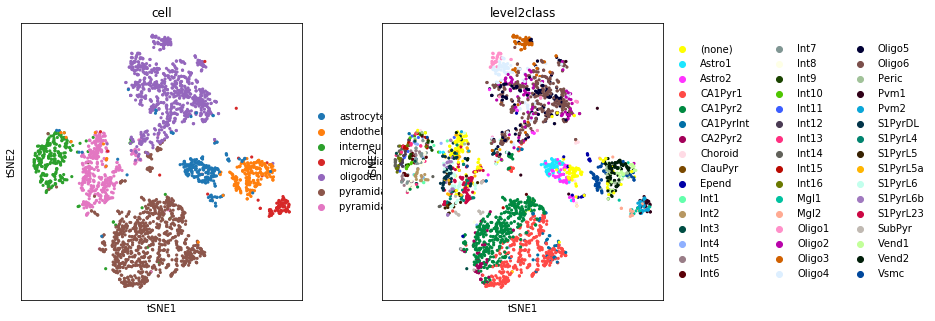

In [48]:
figsize(5,5)
sc.pl.tsne(ad,color=['cell','level2class'])

In [49]:
ad.write('../write/Zeisel_reg.h5')

In [50]:
ls -lh ../write/Zeisel_reg.h5

-rw-r--r--  1 zmiao  384566875   119M  8 Oct 16:02 ../write/Zeisel_reg.h5


# End